In [1]:
import numpy as np
import xarray as xr
import cftime
import matplotlib.pyplot as plt
import dask
import dask.array as dsa

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Import 1pct CO2 sea level data

# Need to extract coordinate data
sea_level_co2_zarr = xr.open_zarr('/scratch/aeb783/data/sea_level_co2.zarr')

data = dsa.from_zarr('/scratch/aeb783/data/sea_level_co2_rechunked.zarr')
coords_dict = {'time': sea_level_co2_zarr['time'],
         'yt_ocean': sea_level_co2_zarr['yt_ocean'],
         'xt_ocean': sea_level_co2_zarr['xt_ocean']}
sea_level = xr.DataArray(data, 
                             dims=('time', 'yt_ocean', 'xt_ocean'),
                             coords=coords_dict)
sea_level

,Array,Chunk
Bytes,284.02 GB,28.40 MB
Shape,"(7305, 2700, 3600)","(7305, 27, 36)"
Count,10001 Tasks,10000 Chunks
Type,float32,numpy.ndarray


In [3]:
# Sea level at NYC (40.7128 N, 74.0060 W)
nyc_coords = (40.6, -74) # Estimated coordinates
nyc_timeseries = sea_level.sel(yt_ocean = nyc_coords[0], xt_ocean = nyc_coords[1], method='nearest')
nyc_timeseries.chunk(chunks = {'time': 7305})

<xarray.DataArray 'from-zarr-fdd7e38dccdd23d82b34ad4ab8301d1c' (time: 7305)>
dask.array<getitem, shape=(7305,), dtype=float32, chunksize=(7305,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    yt_ocean  float64 40.56
    xt_ocean  float64 -73.95

/scratch/aeb783/penv/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


<xarray.DataArray (time: 7305)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    yt_ocean   float64 40.56
    xt_ocean   float64 -73.95
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366

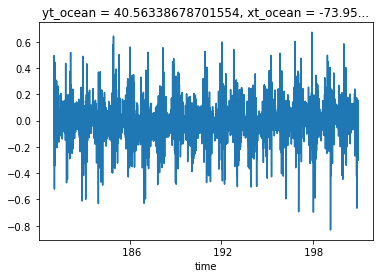

In [4]:
# Remove seasonal cycle
seasonal_cycle = nyc_timeseries.groupby('time.dayofyear').mean().compute();
seasonal_cycle = seasonal_cycle.rolling(dayofyear=10, center=True).mean().compute()
sla = nyc_timeseries.groupby("time.dayofyear") - seasonal_cycle
sla = sla.compute()

sla.plot()
sla

In [5]:
# Function to remove the seasonal cycle
def remove_seasonal_cycle(dsl):
    '''Given a timeseries of daily dynamic sea level (dsl), returns the sea level anomaly (sla).
    A 10-day rolling average is used to smoothen the computed seasonal cycle.'''
    seasonal_cycle = dsl.groupby('time.dayofyear').mean().compute()
    seasonal_cycle = seasonal_cycle.rolling(dayofyear=10, center=True).mean().compute()
    sla = dsl.groupby('time.dayofyear') - seasonal_cycle
    sla = sla.compute()
    return sla

In [6]:
# Create a function which returns the p-percentile for each year in the record.
def return_percentiles(timeseries, q):
    '''Given an xarray timeseries and percentile q, returns an xarray dataarray 
    of the p-percentile of the timeseries for each year.
    
    For instance, given a sea level timeseries of ranging from 1991 to 2000 and q=50,
    this function returns the median sea level over each of the ten years in the record.'''
    
    years = np.unique(timeseries.time.dt.year)
    
    # Initialize xarray DataArray of percentiles
    percentiles = xr.DataArray(np.zeros(len(years)), dims=('year'), coords={'year': years})
    
    for year in years:
        # Select timeseries of particular year
        string_year = '0' + str(int(year))
        current_timeseries = timeseries.sel(time = string_year)
        
        # Determine percentile of timeseries
        percentile = np.nanpercentile(current_timeseries, q)
        
        # Add to DataArray
        percentiles.loc[{'year': year}] = percentile
        
    return percentiles

def plot_median_and_extremes(timeseries, title='', show_regression=True):
    fig, ax = plt.subplots()
    median = return_percentiles(timeseries, 50)
    extremes = return_percentiles(timeseries, 99)
    median.plot(ax=ax, linestyle='', marker='.', color='k', label='median')
    extremes.plot(ax=ax, linestyle='', marker='.', color='r', label='99th percentile')
    ax.set_ylabel('Sea level [meters]')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1,1))
    
    if show_regression:
        # Regression for median
        reg_1 = linear_model.LinearRegression()
        X_median = np.array(median['year']).reshape(-1,1) # Need to reshape into 2D array of shape (num_features, 1)
        Y_median = median.data
        reg_1.fit(X_median, Y_median)
        reg_1.predict(X_median)
        ax.plot(X_median, reg_1.predict(X_median), linestyle='-', color='k')
        
        # Regression for extremes
        reg_2 = linear_model.LinearRegression()
        X_extreme = np.array(extremes['year']).reshape(-1,1)
        Y_extreme = extremes.data
        reg_2.fit(X_extreme, Y_extreme)
        reg_2.predict(X_extreme)
        ax.plot(X_median, reg_2.predict(X_extreme), linestyle='-', color='r')
        
        median_slope = reg_1.coef_[0] * 1000 # Units: mm/year
        extremes_slope = reg_2.coef_[0] * 1000
        
        print('Slope of medians: ', median_slope, 'mm/year')
        print('Slope of extremes: ', extremes_slope, 'mm/year')
        
        print('RMSE medians: ', mean_squared_error(Y_median, reg_1.predict(X_median), squared=False), 'meters')
        print('RMSE extremes: ', mean_squared_error(Y_extreme, reg_1.predict(X_extreme), squared=False), 'meters')

Slope of medians:  0.952244746057611 mm/year
Slope of extremes:  0.38642579541170435 mm/year
RMSE medians:  0.018984587079969622 meters
RMSE extremes:  0.335174554728914 meters


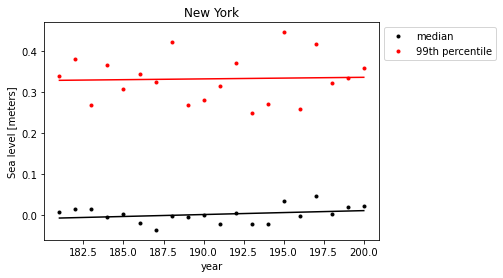

In [7]:
plot_median_and_extremes(sla, 'New York')

Observations:
* Median sea level increases at an average rate of ~1 mm/year.
* Extreme sea level is increasing but at a slower rate than the medians (in a way which may not be statistically significant).
* RMSE spread of medians from the regression is lower for the median data than the extremes data. This may be simply because the distributions have a higher density around the median than the 99th percentile. If we suppose that the shape of the sla distribution doesn't change, but only shifts, this means that differences in the 49th and 50th percentile are much smaller than differences between the 98th and 99th percentile. So sampling from this distribution

In [8]:
# Other cities

# Define dictionary of cities and their associated coordinates
cities_dict = {'New York': (40.6, -74),
               'Miami': (25.76, -80.1),
              'New Orleans': (40.6, -74.0),
              'Halifax': (44.5, -63.5),
              'Boston': (42.3601, -71.0589),
              'Baltimore': (39.1, -76.5),
               'Charleston': (32.7765, -79.8),
               'Tampa': (27.9, -82.4572),
               'Houston': (29.6, -95.0)
              }

/scratch/aeb783/penv/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


Slope of medians:  0.952244746057611 mm/year
Slope of extremes:  0.38642579541170435 mm/year
RMSE medians:  0.018984587079969622 meters
RMSE extremes:  0.335174554728914 meters


/scratch/aeb783/penv/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


Slope of medians:  1.3310442237477558 mm/year
Slope of extremes:  2.01401487104875 mm/year
RMSE medians:  0.009280423073194363 meters
RMSE extremes:  0.10353313441028207 meters


/scratch/aeb783/penv/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


Slope of medians:  0.952244746057611 mm/year
Slope of extremes:  0.38642579541170435 mm/year
RMSE medians:  0.018984587079969622 meters
RMSE extremes:  0.335174554728914 meters


/scratch/aeb783/penv/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


Slope of medians:  1.3898842204782302 mm/year
Slope of extremes:  0.6163198826904583 mm/year
RMSE medians:  0.016815275791800796 meters
RMSE extremes:  0.14743406716375448 meters


/scratch/aeb783/penv/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


Slope of medians:  0.7555339793513594 mm/year
Slope of extremes:  -0.8231368737113203 mm/year
RMSE medians:  0.018245745476990587 meters
RMSE extremes:  0.2429456893699861 meters


/scratch/aeb783/penv/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


Slope of medians:  1.371414365625023 mm/year
Slope of extremes:  -1.2320134442551747 mm/year
RMSE medians:  0.016142513046591204 meters
RMSE extremes:  0.31824441498621314 meters


/scratch/aeb783/penv/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


Slope of medians:  2.3231940722107 mm/year
Slope of extremes:  2.5520865675201994 mm/year
RMSE medians:  0.016805017995510936 meters
RMSE extremes:  0.25136632836681105 meters


/scratch/aeb783/penv/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


Slope of medians:  1.3832244489874161 mm/year
Slope of extremes:  1.0630546817205904 mm/year
RMSE medians:  0.012251861652602992 meters
RMSE extremes:  0.12862637956563167 meters


/scratch/aeb783/penv/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


Slope of medians:  1.3629128176130747 mm/year
Slope of extremes:  0.8275076052300016 mm/year
RMSE medians:  0.013838082371567315 meters
RMSE extremes:  0.1690933219206455 meters


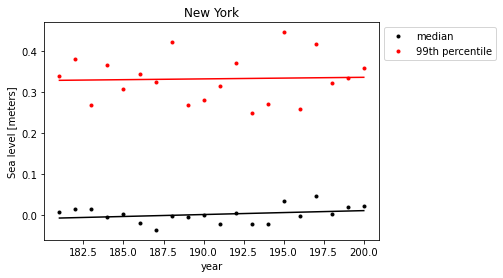

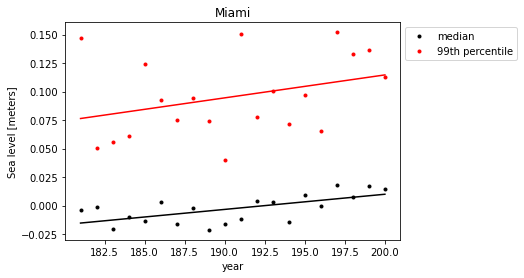

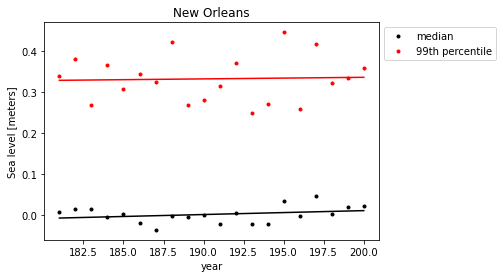

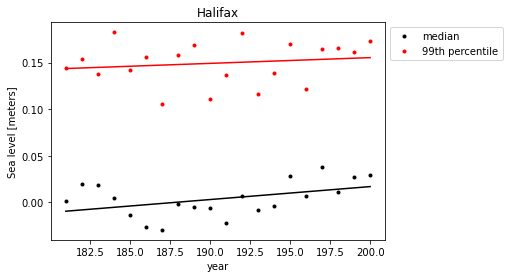

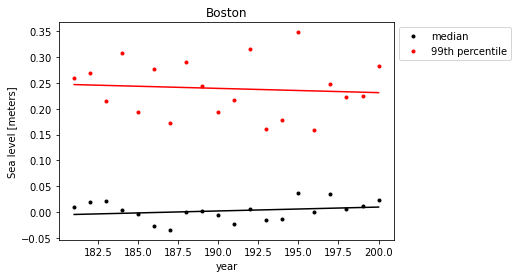

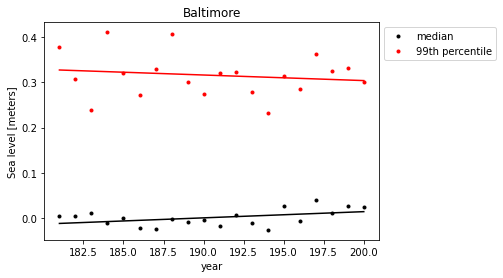

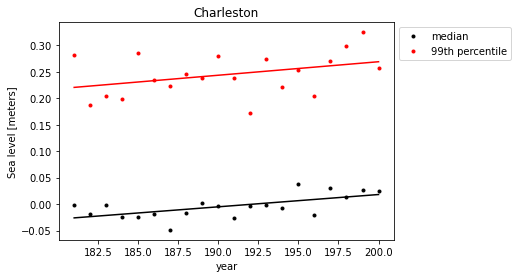

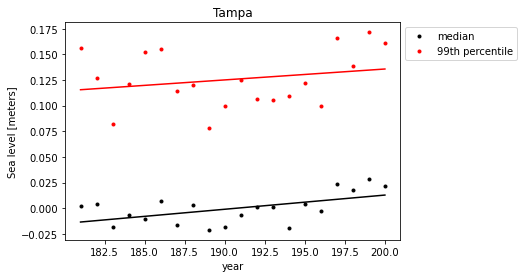

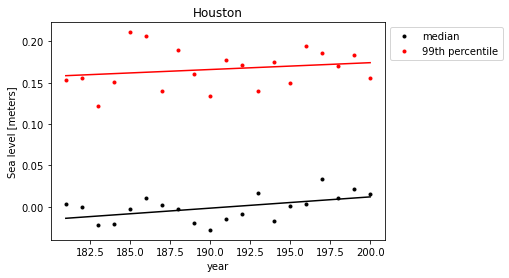

In [10]:
for city in cities_dict:
    sla = remove_seasonal_cycle(sea_level.sel(yt_ocean=cities_dict[city][0], 
                                                xt_ocean=cities_dict[city][1], method='nearest'))
    plot_median_and_extremes(sla, city)

In general, the trend over this 20 year period is positive for the medians along the north american East Coast. The spread for the 99th percentile is pretty large, so it's difficult to make conclusions about the 99th percentile trends.